In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict, Counter
from Individual import Individual, Female, Male
from Household import Household
from Infection import ImmunoInfection
from Bari import Bari
from Village import Village
from Node import Node
from Utility import *
import Utility
import glob
import re

from ete3 import Tree, TreeStyle, NodeStyle 
import copy
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.stats
import dill
from pandas import DataFrame, read_excel, read_csv
fig_directory = '' #replace

In [2]:
import scipy
duration_s = {'A481G': 0.535,
                               'U2909C': 0.277, 
                               'U398C': 0.214,
                               }
def alt_calculate_shed_duration(self,  est_params = [0.3, 0.3, 0.3, 0.3], mutation = None, params = config.params): #u= 12.5, delta = 1.16, sigma = 1.86
        """probability of shedding given Nab at time t (days post infection); 
        assumes that individual was infected at t = 0; time is measured in days
        Equation S1 in Famulaire paper
        delta_t = time (days) since last infection -- survival curve follows lognormal distribution"""
        delta_i = ImmunoInfection.est_params[0]

        if not mutation: #initialize
            w = sum([params.duration_s[locus] for locus in params.loci if (self.genome[locus]) & (locus not in ['syn', 'nonsyn', 'cpg', 'nonsyn_neutral'])])
            M = np.log(params.duration_params['u']) + w
            
            #delta_w = np.sum(delta_s[locus] for locus in params.loci if self.genome[locus]& (locus not in ['syn', 'nonsyn', 'cpg']))
            D = delta_i
            S = np.sqrt(np.absolute(1 + w))
            
            mu = M - D*np.log2(self.prechallenge_immunity)
            std = 0 #S * params.duration_params['sigma']
            self.shed_duration = max(1, np.exp(mu + np.random.normal(scale = std)))
        else: #extend
            std = params.duration_params['sigma']
            self.shed_duration *= (np.exp(params.duration_s[mutation] + np.sqrt(np.absolute(params.duration_s[mutation])) * np.random.normal(scale = std)))
            self.shed_duration = max(1, self.shed_duration)

def calculate_evolving_immunity(est_params):            
    immunity_dict = defaultdict(list)
    ImmunoInfection.est_params = est_params
    ImmunoInfection.calculate_shed_duration = alt_calculate_shed_duration

    for immunity in range(13):
        for _ in range(1):
            M = Male(0)
            M.infection.current_immunity = 2**immunity
            M.death_age = 1000000
            while not M.infection.is_shed:
                M.receive_transmission_dose(dose= 10**100)
            immunity_dict[immunity].append(M)

    for immunity in range(13):
        while np.sum([M.infection.is_shed for M in immunity_dict[immunity]]) >= 1:
            for M in immunity_dict[immunity]:
                M.update(1/365.)
    simulated_immunities = np.asarray([np.mean([M.infection.shed_duration for M in immunity_dict[x]]) for x in range(0, 13,1)])
    return simulated_immunities 

def calculate_nonevo_shed_duration(Nab, u= 30.3, delta = 1.16, sigma = 1.86):
    """probability of shedding given Nab at time t (days post infection); 
    assumes that individual was infected at t = 0; time is measured in days
    Equation S1 in Famulaire paper
    delta_t = time (days) since last infection -- survival curve follows lognormal distribution"""
    mu = np.log(u) - np.log(delta)*np.log2(Nab)
    #scipy stats has weird implementation of parameters
    #the shape parameter (s) is the same as the stdev
    #the scale parameter is the same as the e^(mu)
    return np.exp(mu)

def calculate_distance(params):
    simulated_immunities = calculate_evolving_immunity(params)
    distance = np.sum((simulated_immunities - [calculate_nonevo_shed_duration(2**x) for x in range(0,13,1)])**2)
    return distance

def optimize(x0=[1.16]):        
    params = scipy.optimize.minimize(lambda x: calculate_distance(x),     x0, method='SLSQP')
    return params.x

In [3]:
def calculate_original_shed_duration(Nab,genome = {'A481G':0, 'U2909C':0, 'U398C':0}, mu =12 , delta = 1.16, sigma = 0.3):
    duration_s = {'A481G': 0.535,'U2909C': 0.277,'U398C': 0.214}
    
    w = sum([duration_s[locus] for locus in genome if genome[locus]])
    M = np.log(mu) + w
    S = np.sqrt(np.absolute(1 + w))

    mu = M*(1- 1.15/np.log(12)*np.log2(Nab)) 
    std = S * sigma
    shed_duration = max(1, np.exp(mu)) #+ np.random.normal(scale = std)))
    return(shed_duration)

def calculate_nonevo_shed_duration(Nab, u= 30.3, delta = 1.16, sigma = 1.86):
    """probability of shedding given Nab at time t (days post infection); 
    assumes that individual was infected at t = 0; time is measured in days
    Equation S1 in Famulaire paper
    delta_t = time (days) since last infection -- survival curve follows lognormal distribution"""
    mu = np.log(u) - np.log(delta)*np.log2(Nab)
    #scipy stats has weird implementation of parameters
    #the shape parameter (s) is the same as the stdev
    #the scale parameter is the same as the e^(mu)
    return np.exp(mu)

In [4]:
def normalize(array):
    return np.asarray(array) / np.sum(array)


class Param_Search:
    def __init__(self):
        self.shed_duration = np.asarray([calculate_nonevo_shed_duration(2**x) for x in range(0,13,1)])
        
    

    def calculate_difference(self, params):
        simulated_immunities = calculate_evolving_immunity(params)
        distance = np.sum((simulated_immunities - self.shed_duration)**2)
        return distance
    
    def calculate_distance_distribution(self, priors):
        '''generates a distance distribution (KL divergence technically) and determines the 30th, 10th, 5th percentiles'''
        distances = []
        for _ in range(1000):
            if _ %100 == 0:
                print('calculating distance distribution iteration {iteration} / 1000'.format(iteration = _))
            distance = self.calculate_difference([priors[key]() for key in priors])
            distances.append(distance)
        plt.hist(distances)
        percentiles = [np.percentile(distances, 30), np.percentile(distances, 10), np.percentile(distances, 5), np.percentile(distances, 2.5)]
        return percentiles
    
    def sequential_pmc_ABC(self, n_particles=300, eps = None): 
            '''Population Montecarlo PMC algorithm designed to perform ABC and iteratively adapt the prior/proposal distribution to more closely resemble the posterior
            does this by iteratively reducing the tolerated error and progressively adapting the prior distribution
            follows the Algorithm 2 of Sadegh and vrugt 2014: Approximate Bayesian computation using Markov Chain Monte Carlo simulation: DREAM_ABC_ and the code at https://stackoverflow.com/questions/37496969/population-monte-carlo-implementation
            eps = initial error terms'''
            coefficients_mean = [0.1]
            scales_std = [0.05]
            priors = {}
            alphabet_string='abcdefghijklmnopqrstuvwxyz'
            for mu, sigma, letter in zip(coefficients_mean, scales_std, alphabet_string):
                priors[letter] = lambda: np.random.normal(mu, sigma)
                #priors[letter] = lambda:  scipy.stats.truncnorm.rvs((0-mu)/sigma,
                #                                                    (1-mu)/sigma,
                #                                                    loc=mu,scale=sigma,size=1)[0]



            def computeWeight(prevWeights,prevParticles,prevVariance,currentParticle):
                '''compute the weights needed to adapt the proposal distribution to be closer to the posterior'''
                prior = []
                for mu, std in zip(coefficients_mean, scales_std):
                    prior.append(scipy.stats.norm.pdf(currentParticle, mu,std))
                
                prior =np.prod(prior)
                denom = 0.0
                scale = 1e5
                for i in range(len(prevParticles)):
                    denom += prevWeights[i]  * scipy.stats.norm(scale * currentParticle, 
                                                                               scale * prevVariance).pdf(scale * prevParticles[i])
                return prior/denom    

            if not eps:
                eps = self.calculate_distance_distribution(priors) #automatically calculate the 30th, 10th, 5th percentiles if not given
                print(eps)

            iterations = len(eps)
            distance = 1e9
            variance = {} #for multivariate, this is covariance matrix
            particles = defaultdict(list)
            weights = np.empty([iterations,n_particles])
            simData = np.empty(n_particles)

            for j in range(iterations):
                print('starting {j}th iteration'.format(j=j))
                if j == 0:
                    for i in range(n_particles):
                        while(distance > eps[j]):
                            draw = [priors[key]() for key in priors]
                            while sum(np.asarray(draw) < 0) > 0:
                                draw = [priors[key]() for key in priors]
                            distance = self.calculate_difference(draw)
                        if i in [round(x,0) for x in np.linspace(0, n_particles, 10)]:
                            print(draw, distance)
                            print('particle {i} solution found'.format(i = i))
                        particles[j].append(draw)
                        weights[j][i] = 1./n_particles
                        distance = 1e9
                    particles[j] = np.asarray(particles[j])

                    variance[j] = 2 * np.var(particles[j].T) #np.cov(particles[j].T)
                else:
                    for i in range(n_particles):
                        while(distance > eps[j]):
                            prelim_draw_index = np.random.choice(range(len(particles[j-1])), p = weights[j-1]) #draw a new parameter from the weighted distribution of previously identified parameters; random choice only works on 1-D arrays (no nested)
                            prelim_draw = particles[j-1][prelim_draw_index]
                            #draw = np.random.normal(prelim_draw, np.sqrt(variance[j-1])) #peturb the new prior in proportion to the stdev of the previous iteration
                            #distance = self.calculate_difference([draw])
                            draw = np.random.normal(prelim_draw, variance[j-1]) #multivariate_normal accepts the covariance
                            while  sum(np.asarray(draw) < 0) > 0:
                                draw = np.random.normal(prelim_draw, variance[j-1])
                            distance = self.calculate_difference(draw)
                        if i in [round(x,0) for x in np.linspace(0, n_particles, 10)]:
                            print('particle {i} solution found'.format(i = i))
                            print(draw, distance)

                        particles[j].append(draw)
                        weights[j][i] = computeWeight(weights[j-1],particles[j-1],variance[j-1],particles[j][i])
                        distance = 1e9
                    particles[j] = np.asarray(particles[j])
                    variance[j] = 2 * np.cov(particles[j].T) #np.var(particles[j].T)
                    weights[j] = normalize(weights[j])
            self.posteriors = np.asarray(particles)
            self.max_posteriors = [np.mean(distribution) for distribution in self.posteriors.item()[j].T] 
        

In [5]:
P = Param_Search()

calculating distance distribution iteration 0 / 1000
calculating distance distribution iteration 100 / 1000
calculating distance distribution iteration 200 / 1000
calculating distance distribution iteration 300 / 1000
calculating distance distribution iteration 400 / 1000
calculating distance distribution iteration 500 / 1000
calculating distance distribution iteration 600 / 1000
calculating distance distribution iteration 700 / 1000
calculating distance distribution iteration 800 / 1000
calculating distance distribution iteration 900 / 1000
[367.11866106473053, 241.7371449012553, 191.89300157965965, 166.13245017099504]
starting 0th iteration
[0.12336233685179579] 177.58886621713984
particle 0 solution found
[0.14418001310221068] 290.9442702063472
particle 33 solution found
[0.16650220919969055] 185.4721811412606
particle 67 solution found
[0.10742925280958734] 209.52702587567924
particle 100 solution found
[0.1330268622880354] 199.95069014774757
particle 133 solution found
[0.10647186

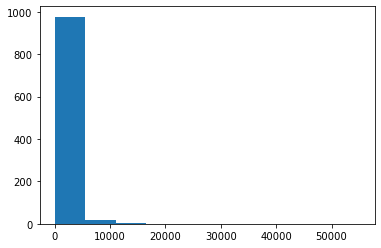

In [6]:
P.sequential_pmc_ABC()

0.120995783661005 0.0942355759039282 0.1517195594867404
[0.12177168003135597]


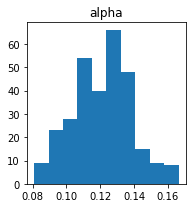

In [32]:
plt.figure(figsize=(10,3))
i = 1
params = ['alpha', 'beta', 'gamma', 'delta']
for posterior in P.posteriors.item()[2].T:
    plt.subplot(1,4,i)
    plt.hist(posterior)
    print(np.mean(posterior), np.percentile(posterior, 5), np.percentile(posterior, 95))
    plt.title(params[i-1])
    i+=1
plt.tight_layout()
print(P.max_posteriors)

In [7]:
def calculate_transmission_fitness(beta, alleles, selection_coefficients):
        denominator = 1
        for a,s in zip(alleles, selection_coefficients):
            denominator *= (1 + s)**a
        w = beta / denominator        
        return w
    
def calculate_transmission_fitness_self(genome, params):
        '''to calculate the transmission fitness of the self infection'''
        beta = params.infectiousness_params['beta']
        selection_coefficients = [params.infectiousness_s[locus] for locus in params.loci]
        alleles = [genome[locus] for locus in params.loci]
        w = ImmunoInfection.calculate_transmission_fitness(beta, alleles, selection_coefficients)
        return w        
        
def attempt_infection(immunity, dose=1, modifier = 1, genome = None, params = config.params): #genome = A481G, U2909C, U398C, NONSYN
        loci = params.loci
        selection_coefficients = [params.infectiousness_s[locus] for locus in loci]
        alleles = [genome[locus] for locus in loci] 
        beta = params.infectiousness_params['beta']
        w = calculate_transmission_fitness(beta, alleles, selection_coefficients)
        p_infection = (1 - (1 + dose/w)**(-params.infectiousness_params['alpha'] * (immunity)**-params.infectiousness_params['gamma'])) #* 0.554
        return(p_infection)
        
        
def attempt_infection_wpv(immunity, dose=1, modifier = 1, genome = None, params = config.params): #genome = A481G, U2909C, U398C, NONSYN
        p_infection = (1 - (1 + dose/2.3)**(-0.44 * (immunity)**-0.46)) #* 0.554
        return(p_infection)
              

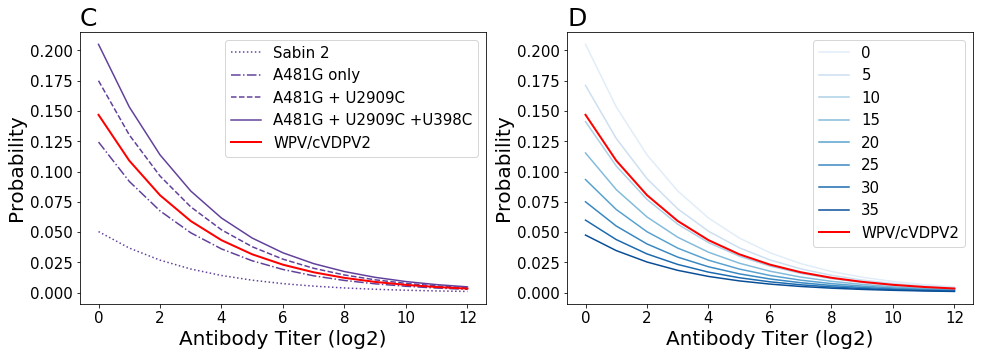

In [8]:
import seaborn as sns
plt.figure(figsize = (16,5))
plt.subplot(1,2,1)
sabin2 = {'A481G': 0, 'U2909C': 0, 'U398C': 0, 'nonsyn': 0, 'syn': 0, 'nonsyn_neutral': 0}
sabin2_1 =  {'A481G': 1, 'U2909C': 0, 'U398C': 0, 'nonsyn': 0, 'syn': 0, 'nonsyn_neutral': 0}
sabin2_2 = {'A481G': 1, 'U2909C': 1, 'U398C': 0, 'nonsyn': 0, 'syn': 0, 'nonsyn_neutral': 0}
sabin2_3 = {'A481G': 1, 'U2909C': 1, 'U398C': 1, 'nonsyn': 0, 'syn': 0, 'nonsyn_neutral': 0}
cpalette = sns.color_palette('Purples_r', 4)
plt.plot([x for x in range(13)], [attempt_infection(2**x, genome = sabin2) for x in range(13)], color = cpalette[0],
         linestyle = 'dotted', label = "Sabin 2")
plt.plot([x for x in range(13)], [attempt_infection(2**x, genome = sabin2_1) for x in range(13)], 
         color = cpalette[0], linestyle = 'dashdot', label = 'A481G only')#"G \u2081,\u2080,\u2080,\u2080,\u2080")
plt.plot([x for x in range(13)], [attempt_infection(2**x, genome = sabin2_2) for x in range(13)], 
         color = cpalette[0], linestyle = 'dashed', label = 'A481G + U2909C') #"G \u2081,\u2081,\u2080,\u2080,\u2080")
plt.plot([x for x in range(13)], [attempt_infection(2**x, genome = sabin2_3) for x in range(13)], 
         color = cpalette[0], label = 'A481G + U2909C +U398C') #G \u2081,\u2081,\u2081,\u2080,\u2080")

plt.plot([x for x in range(13)], [attempt_infection_wpv(2**x) for x in range(13)], color = 'red', 
         linewidth = 2, label = 'WPV/cVDPV2')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Antibody Titer (log2)', fontsize = 20)
plt.ylabel('Probability', fontsize = 20)
legend = plt.legend(fontsize = 15)
legend.get_title().set_fontsize('15') #legend 'Title' fontsize
plt.title('C', fontsize = 25, loc = 'left')



plt.subplot(1,2,2)
cpalette = sns.color_palette('Blues', 8)
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    
for i,x in enumerate(range(0,40,5)):
    sabin2_4 = {'A481G': 1, 'U2909C': 1, 'U398C': 1, 'nonsyn': x, 'syn': 0,'nonsyn_neutral': 0}
    plt.plot([x for x in range(13)], [attempt_infection(2**x, genome = sabin2_4) for x in range(13)], 
             color = cpalette[i], label = x)
plt.plot([x for x in range(13)], [attempt_infection_wpv(2**x) for x in range(13)], color = 'red', linewidth = 2, label = 'WPV/cVDPV2')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Antibody Titer (log2)', fontsize = 20)
plt.ylabel('Probability', fontsize = 20)
legend = plt.legend(fontsize = 15)
legend.get_title().set_fontsize('15') #legend 'Title' fontsize
plt.title('D', fontsize = 25, loc = 'left')
plt.savefig(fig_directory + 'Infectiousness.svg')

In [38]:
def calculate_transmission_fitness_self(genome, params):
        '''to calculate the transmission fitness of the self infection'''
        beta = params.infectiousness_params['beta']
        selection_coefficients = [params.infectiousness_s[locus] for locus in params.loci]
        alleles = [genome[locus] for locus in params.loci]
        w = ImmunoInfection.calculate_transmission_fitness(beta, alleles, selection_coefficients)
        return w        
        
def attempt_infection(immunity, dose=1, modifier = 1, genome = None, params = config.params): #genome = A481G, U2909C, U398C, NONSYN
        loci = params.loci
        selection_coefficients = [params.infectiousness_s[locus] for locus in loci]
        alleles = [genome[locus] for locus in loci] 
        beta = params.infectiousness_params['beta']
        w = calculate_transmission_fitness(beta, alleles, selection_coefficients)
        p_infection = (1 - (1 + dose/w)**(-params.infectiousness_params['alpha'] * (immunity)**-params.infectiousness_params['gamma'])) #* 0.554
        return(p_infection)

[2, 0.61, 0.27, -0.04918589, 0, 0]
[2, 0.61, 0.27, -0.04918589, 0, 0]
[2, 0.61, 0.27, -0.04918589, 0, 0]
[2, 0.61, 0.27, -0.04918589, 0, 0]
[2, 0.61, 0.27, -0.04918589, 0, 0]
[2, 0.61, 0.27, -0.04918589, 0, 0]
[2, 0.61, 0.27, -0.04918589, 0, 0]
[2, 0.61, 0.27, -0.04918589, 0, 0]
[2, 0.61, 0.27, -0.04918589, 0, 0]
[2, 0.61, 0.27, -0.04918589, 0, 0]
[2, 0.61, 0.27, -0.04918589, 0, 0]
[2, 0.61, 0.27, -0.04918589, 0, 0]
[2, 0.61, 0.27, -0.04918589, 0, 0]
[1.82, 0.56, 0.25, -0.04918589, 0, 0]
[1.82, 0.56, 0.25, -0.04918589, 0, 0]
[1.82, 0.56, 0.25, -0.04918589, 0, 0]
[1.82, 0.56, 0.25, -0.04918589, 0, 0]
[1.82, 0.56, 0.25, -0.04918589, 0, 0]
[1.82, 0.56, 0.25, -0.04918589, 0, 0]
[1.82, 0.56, 0.25, -0.04918589, 0, 0]
[1.82, 0.56, 0.25, -0.04918589, 0, 0]
[1.82, 0.56, 0.25, -0.04918589, 0, 0]
[1.82, 0.56, 0.25, -0.04918589, 0, 0]
[1.82, 0.56, 0.25, -0.04918589, 0, 0]
[1.82, 0.56, 0.25, -0.04918589, 0, 0]
[1.82, 0.56, 0.25, -0.04918589, 0, 0]
[1, 0.31, 0.14, -0.04918589, 0, 0]
[1, 0.31, 0.14, 

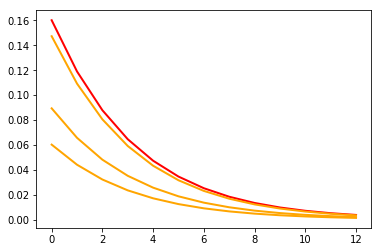

In [55]:
params.infectiousness_s['A481G'] = 2
params.infectiousness_s['U2909C'] = 0.61
params.infectiousness_s['U398C'] = 0.27
plt.plot([x for x in range(13)], [attempt_infection(2**x,genome= {'A481G': 1, 'U2909C': 1, 'U398C': 1, 'nonsyn': 9,'nonsyn_neutral':0, 'syn': 0}, 
                                                    dose = 1) for x in range(13)], color = 'red', 
         linewidth = 2, label = 'WPV/cVDPV2')

params.infectiousness_s['A481G'] = 1.82
params.infectiousness_s['U2909C'] = 0.56
params.infectiousness_s['U398C'] = 0.25
plt.plot([x for x in range(13)], [attempt_infection(2**x,genome= {'A481G': 1, 'U2909C': 1, 'U398C': 1, 'nonsyn': 9,'nonsyn_neutral':0, 'syn': 0}, 
                                                    dose = 1) for x in range(13)], color = 'orange', 
         linewidth = 2, label = 'WPV/cVDPV2')


params.infectiousness_s['A481G'] = 1
params.infectiousness_s['U2909C'] = 0.31
params.infectiousness_s['U398C'] = 0.14
plt.plot([x for x in range(13)], [attempt_infection(2**x,genome= {'A481G': 1, 'U2909C': 1, 'U398C': 1, 'nonsyn': 9,'nonsyn_neutral':0, 'syn': 0}, 
                                                    dose = 1) for x in range(13)], color = 'orange', 
         linewidth = 2, label = 'WPV/cVDPV2')

params.infectiousness_s['A481G'] = 0.5
params.infectiousness_s['U2909C'] = 0.15
params.infectiousness_s['U398C'] = 0.107
plt.plot([x for x in range(13)], [attempt_infection(2**x,genome= {'A481G': 1, 'U2909C': 1, 'U398C': 1, 'nonsyn': 9,'nonsyn_neutral':0, 'syn': 0}, 
                                                    dose = 1) for x in range(13)], color = 'orange', 
         linewidth = 2, label = 'WPV/cVDPV2')

In [ ]:
genome =  {'A481G':0, 'U2909C':0, 'U398C':0}

plt.plot(np.linspace(0, 12, 12), [calculate_nonevo_shed_duration(2**x) for x in np.linspace(0, 12, 12)], color = 'red',
         label = 'NonEvo')

plt.plot(range(0, 13), np.mean(test, axis = 0),  color = 'blue',
         label = 'simulated')
plt.fill_between(range(0, 13), np.percentile(test, 2.5, axis = 0),np.percentile(test, 97.5, axis = 0),  color = 'blue', alpha = 0.3,
         label = 'simulated')

plt.ylabel('Shedding Duration', fontsize = 15)
plt.xlabel('Prechallenge Nab (log2)', fontsize = 15)

plt.legend(fontsize = 12)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Sabin 2 Shedding Duration', fontsize = 20)

In [36]:
shedding = defaultdict(list)
for V in D.villages:
    for key in V.hh_contacts:
        shedding[key] += [individual.infection.is_shed for individual in V.hh_contacts[key]]
for key in shedding:
    print(key, np.mean(shedding[key]))

b-_hh+_i+ nan
b-_hh+_i- nan
b-_hh-_i+ nan
b-_hh-_i- 0.0
b+_hh+_i+ 0.43478260869565216
b+_hh+_i- 0.28125
b+_hh-_i+ 0.0
b+_hh-_i- 0.0


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
class Sim_Results:
    def __init__(self, file, re_search = True):
        if re_search:
            self.param_conditions = re.search('epidemic_(.+)_prevalences.json', file).groups()[0]
        else:
            self.param_conditions = file
        self.file = file
        data = json.load(open(file))
        self.prevalence = data[0]
        #self.r0 = data[1]
        self.cohort_individuals = data[1]
        self.cohort_incidence_time_series = data[2]
        self.transmission_levels = data[3]
        #self.tx_file_list = data[3]
        #self.summarize_transmissions()
        #self.cumulative_crude_incidence = []
        #for x in self.aggregate_crude_incidence:
        #    self.cumulative_crude_incidence.append(np.cumsum(x) / np.sum(x))
        
        
    def summarize_transmissions(self):
        self.aggregate_crude_incidence = []
        self.aggregate_n_events_per_level = defaultdict(list)
        self.aggregate_tx_age_matrix = defaultdict(lambda: defaultdict(list))
        self.cohort_incidences = {}
        for key in self.cohort_incidence_time_series.keys():
            data = self.cohort_incidence_time_series[key]
            self.cohort_incidences[key] = np.sum(data, axis = 1)
                
        #self.cohort_incidences = defaultdict(lambda: np.zeros((100, 161)))
        #self.cumulative_cohort_incidences = defaultdict(lambda: np.zeros((100, 161)))
        '''for index,tx_file in enumerate(self.tx_file_list):
            with open(tx_file, 'rb') as fp:
                transmissions = dill.load(fp)
            crude_incidence, n_events_per_level, tx_age_matrix = extract_transmissions(transmissions)
            self.aggregate_crude_incidence.append(crude_incidence)
            for level in ['hh', 'bari', 'village', 'inter_village']:
                if level in n_events_per_level:
                    self.aggregate_n_events_per_level[level].append(n_events_per_level[level])
                else:
                    self.aggregate_n_events_per_level[level].append(0)
            for level in tx_age_matrix:
                for digitized_source_age in range(17):
                    if digitized_source_age in self.aggregate_tx_age_matrix[level].keys():
                        self.aggregate_tx_age_matrix[level][digitized_source_age].append(tx_age_matrix[level][digitized_source_age])
                    else:
                        self.aggregate_tx_age_matrix[level][digitized_source_age].append(np.zeros(17))
                    
            week_idx = 0'''
        """for day in range(161):
                for Tx in [Tx for Tx in transmissions[0][day] if Tx.secondary_cases != 0]:
                    for cohort in self.cohort_individuals[index]:
                        for level in Tx.tx_history:
                            for event in Tx.tx_history[level]:
                                infected_id = event[0]
                                if infected_id in self.cohort_individuals[index][cohort][0]:
                                    self.cohort_incidences[cohort][index][day] += 1"""
        #for cohort in self.cohort_incidences:
        #    for idx, iteration in enumerate(self.cohort_incidences[cohort]): 
        #        self.cumulative_cohort_incidences[cohort][idx] = np.cumsum(iteration)/ np.sum(iteration)
        
    def plot_prevalence(self, fig_ax = None, color = 'orange', plot_taniuchi_data = False, 
                        x_array = np.asarray([0,1,2,3,4,5,6,7,8,9,10, 14, 18, 22]),
                        plot_percentile=True, conditioned = False):
            fontsize = 12
            if not fig_ax:
                fig, ax = plt.subplots(nrows=3, ncols=4)
                fig.set_size_inches(14,7)
            else:
                fig, ax = fig_ax
            i1,i2,i3 = 0,0,0    
            if conditioned:
                prevalence_dict = defaultdict(list)
                for idx, trace in enumerate(self.prevalence['total']):
                    if trace[-1] < 0.001:
                        for key in self.prevalence:
                            prevalence_dict[key].append(self.prevalence[key][idx])
            
            else:
                prevalence_dict = self.prevalence
            
            infant_cohorts = ['infants_b+_i-', 'infants_b+_i-', 'infants_b-_i-']
            hh_cohorts = ['hh_b+_hh+_i+', 'hh_b+_hh+_i-', 'hh_b+_hh-_i+', 'hh_b+_hh-_i-', 'hh_b-_hh-_i-']
            
            primary_cohort = ['infants_b+_i+', 'hh_b+_hh+_i+','hh_b+_hh+_i-']
            short_transmission = ['infants_b+_i-', 'hh_b+_hh-_i+', 'hh_b+_hh-_i-']
            long_transmission = ['infants_b-_i-', 'hh_b-_hh-_i-']
            for key in primary_cohort + short_transmission + long_transmission:
                if key in primary_cohort:
                    row = 0
                    i = i1
                elif key in long_transmission:
                    row = 2
                    i = i2
                else:
                    row = 1 
                    i = i3
                ax[row][i].plot(x_array, np.mean(prevalence_dict[key], axis = 0), color = color, label = self.param_conditions)
                if plot_percentile:
                    ax[row][i].fill_between(x_array, 
                                         np.percentile(prevalence_dict[key], 95, axis = 0),
                                        np.percentile(prevalence_dict[key], 5, axis = 0), 
                                         color = color, alpha = 0.3)
                ax[row][i].set_title(key.split('_')[0]+ '\n' + ('_').join(key.split('_')[1:])
                                         , fontsize = 12)


                if key in primary_cohort:
                    i1 += 1
                elif key in long_transmission:
                    i2 += 1
                else:
                    i3 += 1

            if plot_taniuchi_data:
                i1,i2,i3 = 0,0,0
                for key in primary_cohort + short_transmission + long_transmission:
                    if key in primary_cohort:
                        row = 0
                        i = i1
                    elif key in long_transmission:
                        row = 2
                        i = i2
                    else:
                        row = 1 
                        i = i3
                    ax[row][i].scatter(x_array[1:],taniuchi_data[key][1:], color = 'grey')
                    ax[row][i].fill_between(x_array[1:], 
                                                 taniuchi_ci[key][0][1:],
                                                 taniuchi_ci[key][1][1:], 
                                                 color = 'grey', alpha = 0.1)
                    if i == 0:
                        ax[row][i].set_ylabel('Prevalence', fontsize = fontsize)
                    if row == 2:
                        ax[row][i].set_xlabel('Weeks')
                    
                    if key in primary_cohort:
                        i1 += 1
                    elif key in long_transmission:
                        i2 += 1
                    else:
                        i3 += 1

            ax[2][2].fill_between(np.asarray([0,1,2,3,4,5,6,7,8,9,10, 14, 18, 22]), 
                             np.percentile(prevalence_dict['total'], 5, axis = 0),
                             np.percentile(prevalence_dict['total'], 95, axis = 0), alpha = 0.3, color =color)

            ax[2][2].plot(np.asarray([0,1,2,3,4,5,6,7,8,9,10, 14, 18, 22]), 
             np.mean(prevalence_dict['total'], axis = 0),  color = color)
            ax[2][2].set_title("Total", fontsize = fontsize)

            fig.tight_layout()
            return fig, ax
        
taniuchi_data = dill.load(open('../data/cohort_stats.json', 'rb'))
taniuchi_n_individuals = dill.load(open('../data/cohort_stats_n_individuals.json', 'rb'))
taniuchi_incidences = json.load(open('../data/cohort_stats_total_incidence.json', 'r'))
for key in taniuchi_data:
    taniuchi_data[key][np.isnan(taniuchi_data[key])] = 0

taniuchi_n_infected = {}
taniuchi_n_uninfected = {}


for key in taniuchi_n_individuals:
    taniuchi_n_infected[key] = taniuchi_data[key] * taniuchi_n_individuals[key]
    taniuchi_n_uninfected[key] = taniuchi_n_individuals[key] - taniuchi_n_infected[key]
import statsmodels.stats.proportion
taniuchi_ci = {}
for key in taniuchi_data:
    if taniuchi_n_individuals[key] > 0:
        p = np.asarray(taniuchi_data[key])
        q = 1- p
        n = taniuchi_n_individuals[key]
        count = p*n
        ci = statsmodels.stats.proportion.proportion_confint(count, n, method = 'agresti_coull')
        taniuchi_ci[key] = ci
    else:
        taniuchi_ci[key] = ([0 for _ in taniuchi_data[key]], [0 for _ in taniuchi_data[key]])


In [3]:
class Transmissions:
    def __init__(self, params, file):
        self.params = params
        self.data = dill.load(open(file, 'rb'))[0]
        self.flatten_transmission()
        for p in [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]:
            self.random_sample(p)
        self.write_csv()
        
    def flatten_transmission(self):
        sim_transmissions = self.data
        tx_events = [['id', 'infectedById', 'timeInfected', 'Event']]
        secondary_cases  = defaultdict(list)
        ids = []
        for day in sim_transmissions:
            for Tx in sim_transmissions[day]:
                if Tx.secondary_cases != 0:
                    secondary_cases[day].append(Tx.secondary_cases)
                    for level in Tx.tx_history:
                        for event in Tx.tx_history[level]:
                            target_id = str(event[0]) + 'n' + str(event[1])
                            tx_events.append([target_id, 
                                                  str(Tx.source_iid) + 'n' +str(Tx.source_n_infected), 
                                                  day, level])
                            ids.append(target_id)
        df = DataFrame(tx_events[1:], columns = tx_events[0])
        self.tx_events = df
        
        print(df.columns)
        roots = []
        for iid in list(df['infectedById']):
            if iid not in list(df['id']):
                roots.append(iid)
        roots = np.unique(roots)
        
        root_events = []
        for root in roots:
            root_events.append([root, 'ROOT', 0, 'mOPV2'])
        self.tx_events = [tx_events[0]] + root_events + tx_events[1:]
        
        self.tx_events = DataFrame(self.tx_events[1:], columns = tx_events[0])
        
        
    def random_sample(self, p):
        n = len(self.tx_events['id'])
        random_indexes = np.random.choice(range(n), round(n*p), replace = False)
        mask = [1 if x in random_indexes else 0 for x in range(n)]
        self.tx_events['p={p}'.format(p=p)] = mask
    
    def write_csv(self):
        fname = 'C:/Users/wwong/Documents/GitHub/MultiscaleModeling/PopSim/transmission_trees/{params}_transmissions.csv'.format(params = self.params)
        self.tx_events.to_csv(fname, sep = ',', index = False)
                            

In [6]:
results = {}
for file in glob.glob('C:/Users/wwong/Documents/GitHub/MultiscaleModeling/PopSim/transmission_trees/transmissions*.pkl'):
    print(file)
    match = re.search('transmissions_(.+).pkl', file)
    params = match.groups()[0]
    print(params)
    results[params] = Transmissions(params, file)


C:/Users/wwong/Documents/GitHub/MultiscaleModeling/PopSim/transmission_trees\transmissions_global_0_0.05.pkl
global_0_0.05
Index(['id', 'infectedById', 'timeInfected', 'Event'], dtype='object')
C:/Users/wwong/Documents/GitHub/MultiscaleModeling/PopSim/transmission_trees\transmissions_global_1_0.05.pkl
global_1_0.05
Index(['id', 'infectedById', 'timeInfected', 'Event'], dtype='object')
C:/Users/wwong/Documents/GitHub/MultiscaleModeling/PopSim/transmission_trees\transmissions_global_5_0.05.pkl
global_5_0.05
Index(['id', 'infectedById', 'timeInfected', 'Event'], dtype='object')
C:/Users/wwong/Documents/GitHub/MultiscaleModeling/PopSim/transmission_trees\transmissions_multiscale_0_0.05.pkl
multiscale_0_0.05
Index(['id', 'infectedById', 'timeInfected', 'Event'], dtype='object')
C:/Users/wwong/Documents/GitHub/MultiscaleModeling/PopSim/transmission_trees\transmissions_multiscale_1_0.05.pkl
multiscale_1_0.05
Index(['id', 'infectedById', 'timeInfected', 'Event'], dtype='object')
C:/Users/wwong